In [305]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from functools import reduce
import xarray as xr

from darts import TimeSeries
from darts.models import *
from darts.dataprocessing.transformers import Scaler


from darts.metrics import *
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.datasets import AirPassengersDataset

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [301]:
# Dataset suivi https://www.data.gouv.fr/fr/datasets/synthese-des-indicateurs-de-suivi-de-lepidemie-covid-19/
link = 'https://www.data.gouv.fr/fr/datasets/r/5c4e1452-3850-4b59-b11c-3dd51d7fb8b5'

In [306]:
from egbz.utils import *

In [357]:
df = pd.read_csv(link)

In [ ]:
list(df.drop(['dep', 'lib_dep', 'lib_reg'], axis=1).columns)

In [390]:
test_01 = df.query('dep=="01"')[['hosp', 'rea']]
test_02 = df.query('dep=="02"')[['hosp', 'rea', 'dep']]

In [369]:
datetime_series = pd.to_datetime(df.date).unique()
datetime_index = pd.DatetimeIndex(datetime_series)
df = df.set_index(datetime_index, drop=True)
df = df.drop(['date'], axis=1, inplace=True)
deps = ['01', '02']

xr.DataArray(test_01[['hosp', 'rea']], coords=[datetime_index, deps], dims=['days', 'zone'])

ValueError: Length mismatch: Expected 53126 rows, received array of length 526

In [377]:
test_01

0       2
1       2
2       2
3       4
4       8
       ..
521    78
522    78
523    76
524    75
525    77
Name: hosp, Length: 526, dtype: int64

In [392]:
datetime_series = pd.to_datetime(df.date).unique()
datetime_index = pd.DatetimeIndex(datetime_series)
zone = df.dep.unique()
features = ['hosp', 'rea']
xarray = xr.DataArray(coords=[datetime_index, zone, features], dims=['time', 'zone', 'feature'])

In [393]:
xarray.loc[:, '01'] = test_01

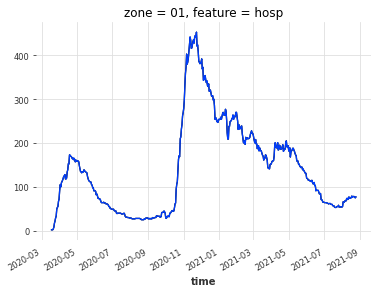

In [411]:
xarray.loc[:, '01', 'hosp'].plot()
xarray.loc[:, '01', 'hosp'].plot();

In [544]:
def create_dataset(
    df: pd.DataFrame,
    feat_cols: Union[List[str], str],
    zone_col: Optional[str]=None,
    time_col: Optional[str]=None,
    cat_cols: Optional[Union[List[str], str]]=None,
) -> xr.DataArray:
    """
    Returns a DataArray that encapsulates the zone, time, categorical
    and features dimension of the data.
    
    Parameters
    ----------
    df
        DataFrame from which the values are extracted.
    feat_cols
        Adds a 'feature' dimension to the DataArray where the values
        come from the feat_cols.
    zone_col
        Adds a 'zone' dimension to the DataArray where the values
        come from the zone_col columns of df.
    time_col
        Adds a 'time' dimension to the DataArray where the values
        come from the time_col columns of df.
    cat_cols
        Adds a 'categorical' dimension to the DataArray where the
        values come from the cat_cols.
    
    Returns
    ----------
    DataArray
        multi-dimensional DataArray constructed from the df DataFrame
    """
    coords = []
    dims = []
    
    if zone_col:
        zone_series = df[zone_col]
        coords.append(zone_series)
        dims.append('zone')
    
    if time_col:
        df[time_col] = pd.to_datetime(df[time_col])
        coords.append(df[time_col])
        dims.append('time')
        
    if cat_cols:
        if isinstance(cat_cols, str):
            cat_cols = [cat_cols]
        coords.append(cat_cols)
        dims.append('cat')
        
    index_df = df.set_index(coords)[feat_cols]
    
    return index_df.to_xarray()

In [545]:
empty_array = create_data_array(
    covid_df, time_col='date',
    zone_col='dep',
    feat_cols=['hosp', 'rea'])

In [546]:
empty_array

<xarray.Dataset>
Dimensions:  (date: 525, dep: 101)
Coordinates:
  * dep      (dep) object '01' '02' '03' '04' '05' ... '972' '973' '974' '976'
  * date     (date) datetime64[ns] 2020-03-18 2020-03-19 ... 2021-08-24
Data variables:
    hosp     (dep, date) int64 2 2 2 4 8 17 22 29 33 49 ... 1 1 1 1 1 1 1 1 1 1
    rea      (dep, date) int64 0 0 0 0 1 3 3 6 6 9 12 ... 0 0 0 0 0 0 0 0 0 0 0

In [518]:
covid_df.set_index(['dep', 'date'])[['hosp', 'rea']]

hosp  rea
dep date                 
01  2020-03-18     2    0
    2020-03-19     2    0
    2020-03-20     2    0
    2020-03-21     4    0
    2020-03-22     8    1
...              ...  ...
976 2021-08-20     1    0
    2021-08-21     1    0
    2021-08-22     1    0
    2021-08-23     1    0
    2021-08-24     1    0

[53025 rows x 2 columns]

In [493]:
import itertools
for x in itertools.product(*[empty_array[x] for x in empty_array.coords]):
    empty_array.loc[x] = 1

In [496]:
covid_df

,dep,date,reg,lib_dep,lib_reg,tx_pos,tx_incid,TO,R,hosp,...,dchosp,reg_rea,incid_hosp,incid_rea,incid_rad,incid_dchosp,reg_incid_rea,pos,pos_7j,cv_dose1
0,01,2020-03-18,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.062612,NaN,2,...,0,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01,2020-03-19,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.132379,NaN,2,...,0,79,1.0,0.0,0.0,0.0,44.0,NaN,NaN,NaN
2,01,2020-03-20,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.155635,NaN,2,...,0,87,0.0,0.0,1.0,0.0,16.0,NaN,NaN,NaN
3,01,2020-03-21,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.173524,NaN,4,...,0,88,3.0,0.0,0.0,0.0,15.0,NaN,NaN,NaN
4,01,2020-03-22,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.212880,NaN,8,...,0,106,3.0,1.0,1.0,0.0,25.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53020,976,2021-08-20,6,Mayotte,Mayotte,1.256958,25.047322,0.000000,NaN,1,...,132,0,0.0,0.0,0.0,0.0,0.0,8.0,70.0,NaN
53021,976,2021-08-21,6,Mayotte,Mayotte,1.199427,23.973865,0.000000,1.1,1,...,132,0,0.0,0.0,0.0,0.0,0.0,7.0,67.0,NaN
53022,976,2021-08-22,6,Mayotte,Mayotte,NaN,NaN,0.000000,NaN,1,...,132,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
53023,976,2021-08-23,6,Mayotte,Mayotte,NaN,NaN,0.000000,NaN,1,...,132,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,33.5


In [500]:
series_df = covid_df.loc[:, covid_df.columns != 'date']

In [501]:
series_df

,dep,reg,lib_dep,lib_reg,tx_pos,tx_incid,TO,R,hosp,rea,...,dchosp,reg_rea,incid_hosp,incid_rea,incid_rad,incid_dchosp,reg_incid_rea,pos,pos_7j,cv_dose1
0,01,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.062612,NaN,2,0,...,0,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.132379,NaN,2,0,...,0,79,1.0,0.0,0.0,0.0,44.0,NaN,NaN,NaN
2,01,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.155635,NaN,2,0,...,0,87,0.0,0.0,1.0,0.0,16.0,NaN,NaN,NaN
3,01,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.173524,NaN,4,0,...,0,88,3.0,0.0,0.0,0.0,15.0,NaN,NaN,NaN
4,01,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.212880,NaN,8,1,...,0,106,3.0,1.0,1.0,0.0,25.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53020,976,6,Mayotte,Mayotte,1.256958,25.047322,0.000000,NaN,1,0,...,132,0,0.0,0.0,0.0,0.0,0.0,8.0,70.0,NaN
53021,976,6,Mayotte,Mayotte,1.199427,23.973865,0.000000,1.1,1,0,...,132,0,0.0,0.0,0.0,0.0,0.0,7.0,67.0,NaN
53022,976,6,Mayotte,Mayotte,NaN,NaN,0.000000,NaN,1,0,...,132,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
53023,976,6,Mayotte,Mayotte,NaN,NaN,0.000000,NaN,1,0,...,132,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,33.5


In [505]:
cart = itertools.product(*[empty_array[x] for x in empty_array.coords])

In [509]:
empty_array.coords

Coordinates:
  * zone     (zone) object '01' '02' '03' '04' '05' ... '972' '973' '974' '976'
  * time     (time) datetime64[ns] 2020-03-18 2020-03-19 ... 2021-08-24
  * cat      (cat) <U3 'age'
  * feat     (feat) <U4 'hosp' 'rea'

In [492]:
empty_array.loc[next(cart)] = 0

In [419]:
covid_df

,dep,date,reg,lib_dep,lib_reg,tx_pos,tx_incid,TO,R,hosp,...,dchosp,reg_rea,incid_hosp,incid_rea,incid_rad,incid_dchosp,reg_incid_rea,pos,pos_7j,cv_dose1
0,01,2020-03-18,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.062612,NaN,2,...,0,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01,2020-03-19,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.132379,NaN,2,...,0,79,1.0,0.0,0.0,0.0,44.0,NaN,NaN,NaN
2,01,2020-03-20,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.155635,NaN,2,...,0,87,0.0,0.0,1.0,0.0,16.0,NaN,NaN,NaN
3,01,2020-03-21,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.173524,NaN,4,...,0,88,3.0,0.0,0.0,0.0,15.0,NaN,NaN,NaN
4,01,2020-03-22,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.212880,NaN,8,...,0,106,3.0,1.0,1.0,0.0,25.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53020,976,2021-08-20,6,Mayotte,Mayotte,1.256958,25.047322,0.000000,NaN,1,...,132,0,0.0,0.0,0.0,0.0,0.0,8.0,70.0,NaN
53021,976,2021-08-21,6,Mayotte,Mayotte,1.199427,23.973865,0.000000,1.1,1,...,132,0,0.0,0.0,0.0,0.0,0.0,7.0,67.0,NaN
53022,976,2021-08-22,6,Mayotte,Mayotte,NaN,NaN,0.000000,NaN,1,...,132,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
53023,976,2021-08-23,6,Mayotte,Mayotte,NaN,NaN,0.000000,NaN,1,...,132,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,33.5


## Garbage

In [ ]:
ts['hosp_dep'].plot()

In [ ]:
ts = from_csv(link, cat_cols=['dep'], time_col='date', value_cols='hosp')
ts

In [ ]:
ts

In [ ]:
ts

In [ ]:
covid_df.query(' & '.join([f'{cat}=="{value}"' for cat, value in zip(['dep', 'lib_dep'], ['01', 'Ain'])]))

In [ ]:
time_col='date'
if time_col:
    datetime_series = pd.to_datetime(df[time_col])
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    df = df.set_index(datetime_index)
    df.drop(time_col, axis=1, inplace=True)

In [ ]:
categories = itertools.product(*['dep', 'lib_dep'])
for x in categories:
    print(str(x))

In [ ]:
cat_cols = ['lib_dep']
value_cols = ['hosp']
categories = itertools.product(*[df[cat].unique() for cat in cat_cols])
d = {f'{col}_{"_".join([x for x in cat])}': 
     df.query(' & '.join([f'{cat_name}=="{cat_value}"'
                            for cat_name, cat_value in zip(cat_cols, [x for x in cat])
                            ])
     )[col]
    for cat in categories
    for col in value_cols
}
pd.DataFrame(d)

In [ ]:
from egbz.utils import *

In [ ]:
plt.plot([1, 2 ,3]);

In [ ]:
df = df.query('dep=="01" | dep=="02"')

In [ ]:
ts = from_df(df, cat_cols=['dep', 'lib_dep'], time_col='date', value_cols=['hosp', 'rea'])

In [ ]:
ts.plot()

In [ ]:
import itertools

for x in itertools.product(*[df[cat].unique() for cat in ['dep', 'lib_dep']]):
    '_'.join([str(y) for y in x])

In [ ]:
'test'
'trolol'

In [ ]:
covid_df.query(' & '.join([f'{cat}=="{value}"' for cat, value in zip(['dep', 'lib_dep'], ['01', 'Ain'])]))

In [ ]:
covid_df.query('dep=="01"')

In [ ]:
df = covid_df
df

In [ ]:
ts.pd_dataframe()

In [ ]:
covid_df = pd.read_csv(link)

In [ ]:
covid_df

In [ ]:
d = {f'{cat}_{col}': cat for cat in covid_df['dep'].unique() for col in ['hosp']}
d

In [ ]:
TimeSeries.from_dataframe(covid_df[['dep','hosp']].query('dep=="01"'))

In [ ]:
from darts import TimeSeries

In [ ]:
TimeSeries.from_dataframe(covid_df[covid_df['dep']=='01'],
                         time_col='date',
                         value_cols='hosp')

In [ ]:
covid_df.keys()

In [ ]:
covid_df.groupby('dep').

In [ ]:
paris_df = covid_df.query('dep==75')

In [ ]:
df = covid_df[['date', 'dep', 'dchosp', 'hosp', 'rea']]
datetime_series = pd.to_datetime(df['date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
df=df.set_index(datetime_index)
df.drop('date',axis=1,inplace=True)
df

In [ ]:
def series_train_test(
    data=covid_df, features=['hosp'],
    timestamp=pd.Timestamp('2021-01-01'), departement=75
):
    # Convert the index into a datetime index
    df = covid_df.query(f'dep=={departement}')[['date'] + features]
    datetime_series = pd.to_datetime(df['date'])
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    df=df.set_index(datetime_index)
    df.drop('date',axis=1,inplace=True)
    
    #
    time_series = {}
    train = {}
    test = {}
    for feature in features:
      series[feature] = TimeSeries.from_dataframe(df[[feature]]) 
      train[feature], test[feature] = time_series[feature].split_before(
          pd.Timestamp(timestamp)
      )
        
    return series, train, test

In [ ]:
time_series, train, test = time_series_train_test(data=paris_df, features['rea'])

In [ ]:
covid_df

In [ ]:
time_series['dchosp']

In [ ]:
train['hosp'].plot(label='train')
test['hosp'].plot(label='test')

In [ ]:
paris_df = covid_df.query('dep==75')[['date', 'TO', 'hosp', 'rea', 'dchosp']]

In [ ]:
paris_df.plot();

In [ ]:
paris_df.info()

In [ ]:
datetime_series = pd.to_datetime(paris_df['date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
df=paris_df.set_index(datetime_index)
df.drop('date',axis=1,inplace=True)
df

In [ ]:

df.plot();

In [ ]:
train, val = series.split_before(pd.Timestamp('2021-01-01'))
train.plot(label='training')
val.plot(label='validation')
plt.legend();

In [ ]:
naive_model = NaiveSeasonal(K=158)
naive_model.fit(train)
naive_forecast = naive_model.predict(300)

series.plot(label='actual')
naive_forecast.plot(label='naive forecast (K=158)')
plt.legend();

In [ ]:
mae(naive_model.predict(220), val)

In [ ]:
!pip install optuna

In [ ]:
import optuna

In [ ]:
def objective(trial):
  naive_model = NaiveSeasonal(K=trial.suggest_int('K', 1, 289))
  naive_model.fit(train)
  return mae(naive_model.predict(220), val)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=289, n_jobs=-1)


In [ ]:
study.best_trial

In [ ]:
plot_acf(train, m = 30, alpha = .05)

In [ ]:
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print('model {} obtains MAE: {:.2f}%'.format(model, mae(val, forecast)))

eval_model(NaiveSeasonal(K=158))
eval_model(ExponentialSmoothing())
eval_model(Prophet())
eval_model(AutoARIMA())
eval_model(Theta())

In [ ]:
expo_model = ExponentialSmoothing()
expo_model.fit(train)
expo_forecast = expo_model.predict(len(val))
series.plot(label='Ground truth')
expo_forecast.plot(label='Prediction')
mae(y_pred, val)

In [ ]:
def objective(trial):
  theta_model = Theta(theta=trial.suggest_float('theta', -10, 10))
  theta_model.fit(train)
  theta_forecast = theta_model.predict(len(val))
  return mae(theta_forecast, val)

theta_study = optuna.create_study(direction='minimize')
theta_study.optimize(objective, n_trials=500, n_jobs=-1)

In [ ]:
theta_study.trials_dataframe().sort_values('value')

In [ ]:
theta_model = Theta(theta=1.422738)
theta_model.fit(train)
theta_forecast = theta_model.predict(len(val))
theta_forecast = theta_model.predict(len(val))
series.plot(label='Ground truth')
theta_forecast.plot(label='Prediction')
mae(y_pred, val)

In [ ]:
df.keys()

In [ ]:
time_series = {}
train_val = {}
for feature in df.keys():
  time_series[feature] = Scaler().fit_transform(TimeSeries.from_dataframe(df[[feature]]))
  train_val[feature] = time_series[feature].split_before(pd.Timestamp('2021-01-01'))

In [ ]:
time_series, train, test = time_series_train_val(timestamp='2021-04-01', features=['hosp', 'rea'])

In [ ]:
model_air = NBEATSModel(input_chunk_length=24, output_chunk_length=12, n_epochs=12)

In [ ]:
model_air.fit(train['hosp'], verbose=True)

In [ ]:
air_forecast = model_air.predict(12)
plt.figure(figsize=(24,16))
time_series['hosp'].plot(label='Ground truth')
air_forecast.plot(label='Prediction')
mape(air_forecast, time_series['hosp'])

In [ ]:
series, train, test = time_series_train_val(
    timestamp=pd.Timestamp('2021-07-01'),
    features=['hosp', 'rea', 'dchosp']
)

In [ ]:
train_series, train, val = time_series_train_val(
    data=train,
    timestamp=pd.Timestamp('2021-01-01'),
    features=['hosp', 'rea', 'dchosp']
)

In [ ]:
test['hosp'].plot()

In [ ]:
my_model = TransformerModel(
    input_chunk_length = 20,
    output_chunk_length = 10,
    batch_size = 16,
    n_epochs = 50,
    model_name = 'air_transformer',
    log_tensorboard=True,
    nr_epochs_val_period = 10,
    d_model = 32,
    nhead = 16,
    num_encoder_layers = 3,
    num_decoder_layers = 3,
    dim_feedforward = 512,
    dropout = 0.1,
    activation = "relu",
    force_reset=True
)

In [ ]:
my_model.fit(series=train['hosp'], val_series=val['hosp'], verbose=True)

In [ ]:
pred = my_model.predict(n=10, series=train['hosp'])
series['hosp'].plot('label')
pred.plot(label='prediction')

In [ ]:
backtest = model_cov.historical_forecasts(series_air_scaled,
                                              past_covariates=air_covariates,
                                              start=0.6,
                                              forecast_horizon=12,
                                              stride=1,
                                              retrain=False,
                                              verbose=True)

series_air_scaled.plot(label='actual')
backtest_cov.plot(label='forecast')
plt.legend();
print('MAPE (using covariates) = {:.2f}%'.format(mape(series_air_scaled, backtest_cov)))

In [ ]:
#this function evaluates a model on a given validation set for n time-steps
def eval_model(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(8,5))
    series.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_series)))
    plt.legend();

eval_model(my_model, 2, series['hosp'], test['hosp'])
